# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

### Импортируем полезные библиотеки, которые пригодятся нам в дальнейшем

In [1]:
#!pip install torchvision
#!pip install spacy~=3.2.6
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import re
import nltk
import spacy
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from functools import partial
from matplotlib.ticker import FormatStrFormatter
from IPython.core.display import display, HTML
from tqdm.notebook import tqdm
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.metrics import accuracy_score, log_loss

### Объявим константы и зададим параметры по умолчанию, которые понадобятся нам в дальнейшем

In [3]:
RANDOM_STATE = 528070
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

display(HTML("<style>.container { width:75% !important; }</style>"))
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rc('font', size=SMALL_SIZE)                                    # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                              # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                              # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                              # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                            # fontsize of the figure title
plt.rc('figure', figsize=(18, 6))                                  # size of the figure
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
set_config(display='diagram')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Загрузка данных:

In [4]:
train_dataset = pd.read_csv('train_dataset.csv')
test_queries = pd.read_csv('test_queries.csv', sep='|', usecols=['image', 'query_id', 'query_text'])
crowd_annotations = pd.read_csv('CrowdAnnotations.tsv',
                                sep='\t',
                                header=None,
                                names=['image', 'query_id', 'crowd', 'approved', 'not_approved'])
expert_annotations = pd.read_csv('ExpertAnnotations.tsv',
                                 sep='\t',
                                 header=None,
                                 names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])

train_dataset.columns.name = 'train_dataset'
test_queries.columns.name = 'test_queries'
crowd_annotations.columns.name = 'crowd_annotations'
expert_annotations.columns.name = 'expert_annotations'
datasets = [train_dataset, test_queries, crowd_annotations, expert_annotations]

### Ознакомимся с набором данных:

In [5]:
for dataset in datasets:
    display(dataset.head())

train_dataset                      image                     query_id  \
0              1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1              1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2              2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3              2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4              2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

train_dataset                                         query_text  
0              A young child is wearing blue goggles and sitt...  
1              A young child is wearing blue goggles and sitt...  
2              A young child is wearing blue goggles and sitt...  
3              A young child is wearing blue goggles and sitt...  
4              A young child is wearing blue goggles and sitt...

test_queries                     query_id  \
0             1177994172_10d143cb8d.jpg#0   
1             1177994172_10d143cb8d.jpg#1   
2             1177994172_10d143cb8d.jpg#2   
3             1177994172_10d143cb8d.jpg#3   
4             1177994172_10d143cb8d.jpg#4   

test_queries                                         query_text  \
0             Two blonde boys , one in a camouflage shirt an...   
1             Two boys are squirting water guns at each other .   
2                       Two boys spraying each other with water   
3             Two children wearing jeans squirt water at eac...   
4             Two young boys are squirting water at each oth...   

test_queries                      image  
0             1177994172_10d143cb8d.jpg  
1             1177994172_10d143cb8d.jpg  
2             1177994172_10d143cb8d.jpg  
3             1177994172_10d143cb8d.jpg  
4             1177994172_10d143cb8d.jpg

crowd_annotations                      image                     query_id  \
0                  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1                  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
2                  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
3                  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
4                  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   

crowd_annotations  crowd  approved  not_approved  
0                   1.00         3             0  
1                   0.00         0             3  
2                   0.00         0             3  
3                   0.00         0             3  
4                   0.00         0             3

expert_annotations                      image                     query_id  \
0                   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1                   1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2                   1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3                   1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4                   1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

expert_annotations  expert_1  expert_2  expert_3  
0                          1         1         1  
1                          1         1         2  
2                          1         1         2  
3                          1         2         2  
4                          1         1         2

### Отобразим информацию для краткого обзора данных:

In [6]:
for dataset in datasets:
    dataset.info()
    print('\n\n', end='')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   crowd         4783

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Объединим краудсорсинговые оценки вместе с оценками экспертов в один датафрейм:

In [7]:
annotations = pd.merge(crowd_annotations, expert_annotations, how='outer', on=['image', 'query_id'])
annotations.head()

image                     query_id  crowd  approved  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   1.00      3.00   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   0.00      0.00   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   0.00      0.00   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   0.00      0.00   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   0.00      0.00   

   not_approved  expert_1  expert_2  expert_3  
0          0.00       NaN       NaN       NaN  
1          3.00       NaN       NaN       NaN  
2          3.00       NaN       NaN       NaN  
3          3.00       NaN       NaN       NaN  
4          3.00       NaN       NaN       NaN

### Добавим соответствующие текстовые описания в таблицу:

In [8]:
data = pd.merge(annotations, train_dataset[['query_id', 'query_text']].drop_duplicates(), how='inner', on=['query_id'])
data.head()

image                     query_id  crowd  approved  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   1.00      3.00   
1  2182488373_df73c7cc09.jpg  1056338697_4f7d7ce270.jpg#2   0.00      0.00   
2  2594042571_2e4666507e.jpg  1056338697_4f7d7ce270.jpg#2   0.00      0.00   
3  2843695880_eeea6c67db.jpg  1056338697_4f7d7ce270.jpg#2   0.00      0.00   
4  2892995070_39f3c9a56e.jpg  1056338697_4f7d7ce270.jpg#2   0.00      0.00   

   not_approved  expert_1  expert_2  expert_3  \
0          0.00       NaN       NaN       NaN   
1          3.00       NaN       NaN       NaN   
2          3.00       NaN       NaN       NaN   
3          3.00       NaN       NaN       NaN   
4          3.00       NaN       NaN       NaN   

                                          query_text  
0  A woman is signaling is to traffic , as seen f...  
1  A woman is signaling is to traffic , as seen f...  
2  A woman is signaling is to traffic , as seen f...  
3  A woman is signaling is to traffic , as seen f...  
4  A woman is signaling is to traffic , as seen f...

### Переведём долю людей, подтвердивших, что описание соответствует изображению в оценку (из $[0, 1]$ в $\{1, 2, 3, 4\}$):

Заметим, что получившаяся на данном этапе предобработки данных оценка может принимать дробные значения

1.00    40932
1.50        3
1.60       22
1.75       94
2.00     2962
2.20        8
2.50       27
2.80        7
3.00     1348
3.25        9
3.40        4
4.00     1305
Name: crowd, dtype: int64

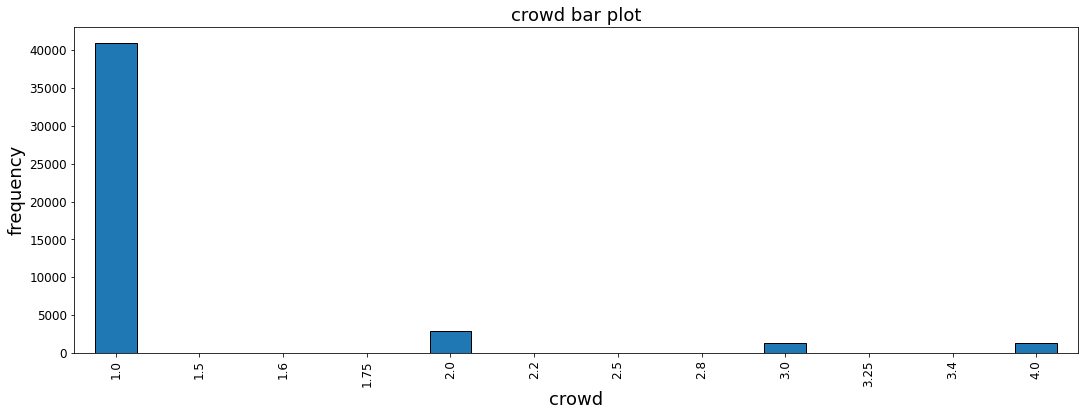

In [9]:
data['crowd'] = data['crowd'] * 3 + 1

values = data['crowd'].value_counts().sort_index()
values.index = np.round(values.index, 2)
display(values)

ax = values.plot(kind='bar', title='crowd bar plot', xlabel='crowd', ylabel='frequency', edgecolor='black')

### Рассчитаем среднюю оценку экспертов:

Заметим, что получившаяся на данном этапе предобработки данных оценка может принимать дробные значения

1.00    2350
1.33     965
1.67     689
2.00     678
2.33     324
2.67     193
3.00     241
3.33      75
3.67      60
4.00     247
Name: expert, dtype: int64

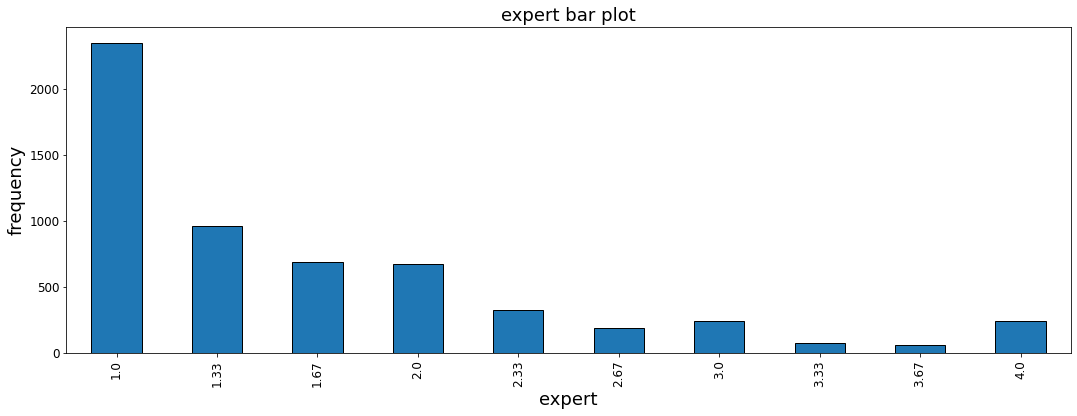

In [10]:
data['expert'] = data[['expert_1', 'expert_2', 'expert_3']].mean(axis=1)

values = data['expert'].value_counts().sort_index()
values.index = np.round(values.index, 2)
display(values)

ax = values.plot(kind='bar',
                 title='expert bar plot',
                 xlabel='expert',
                 ylabel='frequency',
                 edgecolor='black')

### Из краудсорсинговых и экспертных оценок рассчитаем общую оценку:

In [11]:
def formula(row):
    if np.isnan(row['expert']):
        result = row['crowd']
    elif np.isnan(row['crowd']):
        result =  row['expert']
    else:
        result = 0.6 * row['expert'] + 0.4 * row['crowd']
        
    return int(np.round(result))

Объединим краудсорсинговые и экспертные оценки по эвристической формуле: $y = 0.6 * expert + 0.4 * crowd$

In [12]:
data['target'] = data.apply(formula, axis=1)

### Продемонстрируем дисбаланс классов:

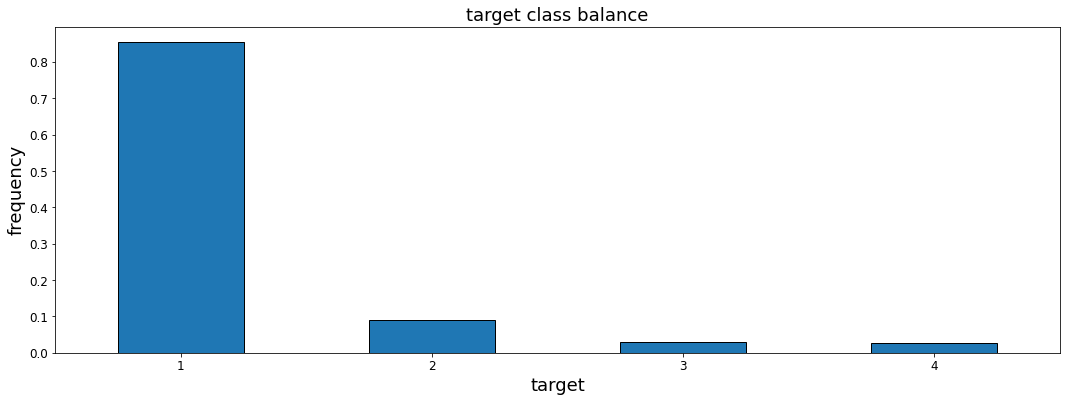

In [13]:
data['target'].value_counts(normalize=True).sort_index().plot(kind='bar',
                                                              rot=0,
                                                              title='target class balance',
                                                              xlabel='target',
                                                              ylabel='frequency',
                                                              edgecolor='black');

### Добавим полный путь для изображений:

In [14]:
data.image = 'train_images/' + data.image

### Удалим лишние столбцы:

In [15]:
data.drop(['expert', 'expert_1', 'expert_2', 'expert_3',
           'crowd', 'approved', 'not_approved', 'query_id'],
          axis=1,
          inplace=True)

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

### Вручную удалим все строки с изображениями детей:

In [16]:
restricted_images = [
    '3767841911_6678052eb6.jpg', '3741827382_71e93298d0.jpg', '3741462565_cc35966b7a.jpg',
    '3737539561_d1dc161040.jpg', '3716244806_97d5a1fb61.jpg', '3701291852_373ea46bb6.jpg',
    '3697359692_8a5cdbe4fe.jpg', '3694064560_467683205b.jpg', '3658427967_6e2e57458d.jpg', 
    '3657016761_d553e514d9.jpg', '3639967449_137f48b43d.jpg', '3630332976_fdba22c50b.jpg',
    '3627011534_485f667b10.jpg', '3605676864_0fb491267e.jpg', '3605061440_1d08c80a57.jpg',
    '3596131692_91b8a05606.jpg', '3589895574_ee08207d26.jpg', '3564312955_716e86c48b.jpg',
    '3549583146_3e8bb2f7e9.jpg', '3545652636_0746537307.jpg', '3538213870_9856a76b2a.jpg', 
    '3523874798_9ba2fa46e3.jpg', '3523474077_16e14bc54c.jpg', '3521374954_37371b49a4.jpg',
    '3484649669_7bfe62080b.jpg', '3482062809_3b694322c4.jpg', '3471841031_a949645ba8.jpg',
    '3457045393_2bbbb4e941.jpg', '3456362961_d8f7e347a8.jpg', '3453259666_9ecaa8bb4b.jpg',
    '3449114979_6cdc3e8da8.jpg', '3433982387_3fa993cf5a.jpg', '3427233064_6af01bfc5c.jpg', 
    '3427118504_93126c83e0.jpg', '3421789737_f625dd17ed.jpg', '3399284917_721aefe2a7.jpg',
    '3388330419_85d72f7cda.jpg', '3361990489_92244a58ef.jpg', '3350786891_6d39b234e9.jpg',
    '3347666612_659e6e2207.jpg', '3325497914_f9014d615b.jpg', '3320032226_63390d74a6.jpg',
    '3295391572_cbfde03a10.jpg', '3280052365_c4644bf0a5.jpg', '3246991821_750a3097e2.jpg',
    '3245460937_2710a82709.jpg', '3245070961_8977fdd548.jpg', '3217910740_d1d61c08ab.jpg',
    '3217266166_4e0091860b.jpg', '3208074567_ac44aeb3f3.jpg', '3203453897_6317aac6ff.jpg', 
    '3201427741_3033f5b625.jpg', '3192069971_83c5a90b4c.jpg', '3185409663_95f6b958d8.jpg',
    '3143982558_9e2d44c155.jpg', '3143155555_32b6d24f34.jpg', '3119875880_22f9129a1c.jpg', 
    '3116769029_f5a76f04ba.jpg', '3114944484_28b5bb9842.jpg', '3108197858_441ff38565.jpg',
    '3080056515_3013830309.jpg', '3079787482_0757e9d167.jpg', '3072114570_e1c0127529.jpg',
    '3051384385_c5c850c1f8.jpg', '3030566410_393c36a6c5.jpg', '3025549604_38b86198f5.jpg',
    '3024172109_a10198e1dd.jpg', '3003691049_f4363c2d5c.jpg', '2991994415_504d1c0a03.jpg',
    '2966552760_e65b22cd26.jpg', '2963573792_dd51b5fbfb.jpg', '2929506802_5432054d77.jpg',
    '2928152792_b16c73434a.jpg', '2921094201_2ed70a7963.jpg', '2913965136_2d00136697.jpg',
    '2910758605_73a3f5a5c2.jpg', '2905942129_2b4bf59bc0.jpg', '2901074943_041aba4607.jpg',
    '2878190821_6e4e03dc5f.jpg', '2844641033_dab3715a99.jpg', '2844018783_524b08e5aa.jpg',
    '2842865689_e37256d9ce.jpg', '2830869109_c4e403eae6.jpg', '2797149878_bb8e27ecf9.jpg',
    '2774430374_fee1d793e7.jpg', '2762301555_48a0d0aa24.jpg', '2757803246_8aa3499d26.jpg',
    '2718024196_3ff660416a.jpg', '2706766641_a9df81969d.jpg', '2693425189_47740c22ed.jpg',
    '2689001252_e0016c89f0.jpg', '2683963310_20dcd5e566.jpg', '2675685200_0913d84d9b.jpg',
    '2667015110_1670324a33.jpg', '2660008870_b672a4c76a.jpg', '2652522323_9218afd8c2.jpg',
    '2648165716_02e2e74fd6.jpg', '2647049174_0fb47cee2e.jpg', '2646116932_232573f030.jpg',
    '2646046871_c3a5dbb971.jpg', '2631300484_be8621d17b.jpg', '2616643090_4f2d2d1a44.jpg',
    '2608289957_044849f73e.jpg', '2594042571_2e4666507e.jpg', '2588927489_f4da2f11ec.jpg',
    '2587818583_4aa8e7b174.jpg', '2577972703_a22c5f2a87.jpg', '2549968784_39bfbe44f9.jpg',
    '2544426580_317b1f1f73.jpg', '2544182005_3aa1332bf9.jpg', '2533642917_a5eace85e6.jpg',
    '2526041608_a9775ab8d7.jpg', '2522297487_57edf117f7.jpg', '2521770311_3086ca90de.jpg',
    '2510020918_b2ca0fb2aa.jpg', '2501595799_6316001e89.jpg', '2498897831_0bbb5d5b51.jpg',
    '2490768374_45d94fc658.jpg', '2484190118_e89363c465.jpg', '2480327661_fb69829f57.jpg',
    '2479652566_8f9fac8af5.jpg', '2475162978_2c51048dca.jpg', '2473738924_eca928d12f.jpg',
    '2461616306_3ee7ac1b4b.jpg', '2460797929_66446c13db.jpg', '2458269558_277012780d.jpg',
    '2453971388_76616b6a82.jpg', '2450299735_62c095f40e.jpg', '2447284966_d6bbdb4b6e.jpg',
    '2445283938_ff477c7952.jpg', '2436081047_bca044c1d3.jpg', '2431832075_00aa1a4457.jpg',
    '2415803492_56a673dc25.jpg', '2393264648_a280744f97.jpg', '2373234213_4ebe9c4ee5.jpg',
    '2370481277_a3085614c9.jpg', '2358554995_54ed3baa83.jpg', '2354540393_a149722680.jpg',
    '2351479551_e8820a1ff3.jpg', '2333288869_8c01e4c859.jpg', '2288099178_41091aa00c.jpg',
    '2274992140_bb9e868bb8.jpg', '2271755053_e1b1ec8442.jpg', '2251747182_6b67a3ab8b.jpg',
    '2228022180_9597b2a458.jpg', '2215136723_960edfea49.jpg', '2208310655_a3d83080c5.jpg',
    '2208067635_39a03834ca.jpg', '2197275664_fabcf3424b.jpg', '2194286203_5dc620006a.jpg',
    '2160266952_a2ab39191b.jpg', '2140182410_8e2a06fbda.jpg', '2128119486_4407061c40.jpg',
    '2120383553_5825333a3f.jpg', '2064790732_219e52e19c.jpg', '2061354254_faa5bd294b.jpg',
    '2021613437_d99731f986.jpg', '1682079482_9a72fa57fa.jpg', '1572532018_64c030c974.jpg',
    '1561658940_a947f2446a.jpg', '1509786421_f03158adfc.jpg', '1490670858_e122df2560.jpg',
    '1467533293_a2656cc000.jpg', '1446053356_a924b4893f.jpg', '1427391496_ea512cbe7f.jpg',
    '1415591512_a84644750c.jpg', '1408958345_68eea9a4e4.jpg', '1402640441_81978e32a9.jpg',
    '1387785218_cee67735f5.jpg', '1386964743_9e80d96b05.jpg', '1356796100_b265479721.jpg',
    '1352410176_af6b139734.jpg', '1348304997_afe60a61df.jpg', '1343426964_cde3fb54e8.jpg',
    '1317292658_ba29330a0b.jpg', '1287475186_2dee85f1a5.jpg', '1248940539_46d33ed487.jpg',
    '1237985362_dbafc59280.jpg', '1224851143_33bcdd299c.jpg', '1220401002_3f44b1f3f7.jpg',
    '1131932671_c8d17751b3.jpg', '1122944218_8eb3607403.jpg', '1096395242_fc69f0ae5a.jpg',
    '979383193_0a542a059d.jpg', '917574521_74fab68514.jpg', '909191414_1cf5d85821.jpg',
    '820169182_f5e78d7d19.jpg', '758921886_55a351dd67.jpg', '751737218_b89839a311.jpg',
    '747921928_48eb02aab2.jpg', '732468337_a37075225e.jpg', '700884207_d3ec546494.jpg',
    '624742559_ff467d8ebc.jpg', '583174725_6b522b621f.jpg', '566397227_a469e9e415.jpg',
    '543007912_23fc735b99.jpg', '542317719_ed4dd95dc2.jpg', '540721368_12ac732c6c.jpg',
    '539751252_2bd88c456b.jpg', '537532165_e4b7c0e61a.jpg', '533979933_a95b03323b.jpg',
    '533713007_bf9f3e25b4.jpg', '522063319_33827f1627.jpg', '514990193_2d2422af2c.jpg',
    '510531976_90bbee22a2.jpg', '509123893_07b8ea82a9.jpg', '497791037_93499238d8.jpg',
    '496110746_a93ca191ae.jpg', '493109089_468e105233.jpg', '491405109_798222cfd0.jpg',
    '488408004_a1e26d4886.jpg', '476233374_e1396998ef.jpg', '464251704_b0f0c4c87a.jpg',
    '452419961_6d42ab7000.jpg', '444057017_f1e0fcaef7.jpg', '398662202_97e5819b79.jpg',
    '350443876_c9769f5734.jpg', '224369028_b1ac40d1fa.jpg', '197504190_fd1fc3d4b7.jpg',
    '191003285_edd8d0cf58.jpg', '170100272_d820db2199.jpg', '154871781_ae77696b77.jpg',
    '136644343_0e2b423829.jpg', '106490881_5a2dd9b7bd.jpg'
]

data = data[data.apply(lambda row: row['image'] not in restricted_images, axis=1)]

### Удалим строки с описанием детей:

In [17]:
restricted_subtexts = ['young boy', 'little boy', 'small boy',
                       'young girl', 'little girl', 'Little girl', 'small girl',
                       'child', 'young child', 'small child',
                       'kid', 'Kid', 'baby', 'babies'
]
restricted_texts = [
    text for text in data['query_text'].unique()
    if any(restricted_subtext in text for restricted_subtext in restricted_subtexts)
]

data = data[data.apply(lambda row: row['query_text'] not in restricted_texts, axis=1)]
data = data.reset_index(drop=True)

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

### Используем предобученную Resnet18 модель для векторизации изображений:

In [18]:
resnet = models.resnet18(weights='IMAGENET1K_V1')
for param in resnet.parameters():
    param.requires_grad_(False)
    
modules = list(resnet.children())[:-2]
resnet = nn.Sequential(*modules)
resnet.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.5MB/s]


### Создадим пайплайн для векторизации изображений:

In [19]:
# Функция открывает и векторизует изображения
def vectorize_images(images):
    image_vectors = []
    for image in images:
        input_tensor = preprocess(Image.open(image).convert('RGB'))
        output_tensor = resnet(input_tensor.unsqueeze(0)).flatten()
        image_vectors.append(output_tensor.numpy())
        
    return image_vectors

image_vectorizer = Pipeline(steps=[('image_vectorizer', FunctionTransformer(vectorize_images))], memory='tmp/cache')
image_vectorizer

Pipeline(memory='tmp/cache',
         steps=[('image_vectorizer',
                 FunctionTransformer(func=<function vectorize_images at 0x7f9f08f88790>))])

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


### Создадим пайплайн для векторизации описаний:

In [20]:
# Функция удаляет лишние символы из массива текстов
def clear_texts(texts):
    return texts.apply(lambda text: ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split()))

# Функия лемматизирует массив текстов
def lemmatize_texts(texts):
    return texts.apply(lambda text: ' '.join([token.lemma_ for token in nlp(text)]))

text_vectorizer = Pipeline(steps=[('text_cleanizer', FunctionTransformer(clear_texts)),
                                  ('text_lemmatizer', FunctionTransformer(lemmatize_texts)),
                                  ('text_vectorizer', TfidfVectorizer())],
                           memory='tmp/cache')
text_vectorizer

Pipeline(memory='tmp/cache',
         steps=[('text_cleanizer',
                 FunctionTransformer(func=<function clear_texts at 0x7f9f08f321f0>)),
                ('text_lemmatizer',
                 FunctionTransformer(func=<function lemmatize_texts at 0x7f9f08f32160>)),
                ('text_vectorizer', TfidfVectorizer())])

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

### Напишем функцию для обьединения векторов:

In [21]:
# Функция получает на вход векторизацию уникальных изображений, векторизацию уникальных описаний и генерирует общий вектор
def generate_vectors(batch, image_vectors, text_vectors):
    vectors = pd.concat([image_vectors.loc[batch['image'].values].reset_index(drop=True),
                         text_vectors.loc[batch['query_text'].values].reset_index(drop=True)], axis=1)
    vectors.columns = range(vectors.columns.size)
    return vectors

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Разделим данные на обучающую и валидационную выборки в соотношении $75\%$/$25\%$:

In [22]:
gss = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=RANDOM_STATE)
train_indices, valid_indices = next(gss.split(X=data.drop(columns=['target']), y=data['target'], groups=data['image']))
train_data, valid_data = data.loc[train_indices].reset_index(drop=True), data.loc[valid_indices].reset_index(drop=True)

### Векторизуем уникальные изображения из выборок:

Будем использовать созданный ранее пайплайн для векторизации изображений. Применим метод `fit_transform` для тренировочной выборки и метод `transform` для валидационной выборки и объединим их в один датафрейм

In [23]:
%%time
train_images = train_data.image.drop_duplicates()
valid_images = valid_data.image.drop_duplicates()
image_vectors = pd.concat([pd.DataFrame(image_vectorizer.fit_transform(train_images), index=train_images),
                           pd.DataFrame(image_vectorizer.transform(valid_images), index=valid_images)])
image_vectors = image_vectors.loc[~image_vectors.index.duplicated()]
image_vectors

CPU times: user 2min 21s, sys: 1.22 s, total: 2min 22s
Wall time: 2min 42s


0      1      2      3      4      \
image                                                                       
train_images/1056338697_4f7d7ce270.jpg   1.46   1.46   0.00   0.00   0.00   
train_images/2594042571_2e4666507e.jpg   0.00   0.32   0.80   0.72   0.58   
train_images/2843695880_eeea6c67db.jpg   0.89   2.07   1.46   0.72   0.00   
train_images/2892995070_39f3c9a56e.jpg   0.00   0.00   0.00   0.00   0.00   
train_images/2934359101_cdf57442dc.jpg   1.04   1.61   2.07   2.20   3.10   
...                                       ...    ...    ...    ...    ...   
train_images/245895500_a4eb97af02.jpg    0.28   0.67   0.00   0.00   0.00   
train_images/3572267708_9d8a81d4a4.jpg   0.64   0.31   0.25   0.18   1.16   
train_images/2238019823_79318d1f11.jpg   1.52   3.66   4.97   6.15   6.64   
train_images/3187395715_f2940c2b72.jpg   0.00   0.00   0.00   0.55   0.68   
train_images/363617160_6cb0c723be.jpg    0.00   0.00   0.00   0.00   0.00   

                                        5      6      7      8      9      \
image                                                                       
train_images/1056338697_4f7d7ce270.jpg   0.00   0.00   2.00   2.57   2.13   
train_images/2594042571_2e4666507e.jpg   1.10   0.91   0.00   0.00   0.00   
train_images/2843695880_eeea6c67db.jpg   0.00   0.00   2.07   3.83   2.86   
train_images/2892995070_39f3c9a56e.jpg   0.00   0.00   0.00   0.00   0.00   
train_images/2934359101_cdf57442dc.jpg   3.79   2.74   2.42   3.85   5.45   
...                                       ...    ...    ...    ...    ...   
train_images/245895500_a4eb97af02.jpg    0.00   0.00   0.65   0.52   0.00   
train_images/3572267708_9d8a81d4a4.jpg   2.73   2.23   0.88   0.00   0.00   
train_images/2238019823_79318d1f11.jpg   5.05   2.82   2.26   4.95   6.63   
train_images/3187395715_f2940c2b72.jpg   0.88   0.32   0.00   0.46   0.00   
train_images/363617160_6cb0c723be.jpg    0.00   0.32   0.00   0.55   0.90   

                                        ...  25078  25079  25080  25081  \
image                                   ...                               
train_images/1056338697_4f7d7ce270.jpg  ...   0.16   1.22   0.80   0.00   
train_images/2594042571_2e4666507e.jpg  ...   0.00   0.33   0.08   0.00   
train_images/2843695880_eeea6c67db.jpg  ...   0.00   0.00   0.00   0.00   
train_images/2892995070_39f3c9a56e.jpg  ...   0.78   1.30   0.20   0.00   
train_images/2934359101_cdf57442dc.jpg  ...   0.00   0.00   0.00   1.43   
...                                     ...    ...    ...    ...    ...   
train_images/245895500_a4eb97af02.jpg   ...   1.07   2.77   2.44   0.00   
train_images/3572267708_9d8a81d4a4.jpg  ...   1.43   1.23   0.06   0.27   
train_images/2238019823_79318d1f11.jpg  ...   2.07   0.52   0.00   1.22   
train_images/3187395715_f2940c2b72.jpg  ...   2.32   4.00   2.88   0.00   
train_images/363617160_6cb0c723be.jpg   ...   0.00   0.73   0.11   0.00   

                                        25082  25083  25084  25085  25086  \
image                                                                       
train_images/1056338697_4f7d7ce270.jpg   0.00   0.00   0.00   0.00   0.00   
train_images/2594042571_2e4666507e.jpg   0.00   0.00   0.00   0.00   1.04   
train_images/2843695880_eeea6c67db.jpg   0.00   0.00   0.00   0.00   0.00   
train_images/2892995070_39f3c9a56e.jpg   0.00   0.00   0.53   0.23   0.10   
train_images/2934359101_cdf57442dc.jpg   1.62   0.42   1.19   0.57   0.26   
...                                       ...    ...    ...    ...    ...   
train_images/245895500_a4eb97af02.jpg    0.00   0.00   0.00   0.03   0.71   
train_images/3572267708_9d8a81d4a4.jpg   0.45   0.38   0.00   0.00   0.00   
train_images/2238019823_79318d1f11.jpg   4.65   6.34   5.49   2.14   0.00   
train_images/3187395715_f2940c2b72.jpg   0.00   0.45   0.52   0.54   1.53   
train_images/363617160_6cb0c723be.jpg    0.00   0.00   0.00   0.00   0.80   

                                        25087  
image     

### Векторизуем уникальные описания из выборок:

Будем использовать созданный ранее пайплайн для векторизации описаний. Применим метод `fit_transform` для тренировочной выборки и метод `transform` для валидационной выборки и объединим их в один датафрейм

In [24]:
%%time
train_texts = train_data.query_text.drop_duplicates()
valid_texts = valid_data.query_text.drop_duplicates()
text_vectors = pd.concat([pd.DataFrame(text_vectorizer.fit_transform(train_texts).todense(), index=train_texts),
                          pd.DataFrame(text_vectorizer.transform(valid_texts).todense(), index=valid_texts)])
text_vectors = text_vectors.loc[~text_vectors.index.duplicated()]
text_vectors

CPU times: user 1.82 s, sys: 4.81 ms, total: 1.83 s
Wall time: 2.09 s


0     1     2     3     \
query_text                                                                   
A woman is signaling is to traffic , as seen fr...  0.00  0.00  0.00  0.00   
A boy in glasses is wearing a red shirt .           0.00  0.00  0.00  0.00   
A woman wearing black clothes , a purple scarf ...  0.00  0.00  0.00  0.00   
An older woman with blond hair rides a bicycle ...  0.00  0.00  0.00  0.00   
A woman wearing a white glove peers over the cr...  0.00  0.00  0.00  0.00   
...                                                  ...   ...   ...   ...   
Three basketball players leap to grab a ball .      0.00  0.00  0.00  0.00   
A musician plays a drum while his hair covers h...  0.00  0.00  0.00  0.00   
People are inspecting sound equipment indoors .     0.00  0.00  0.00  0.00   
A tennis player is carrying a tennis racket .       0.00  0.00  0.00  0.00   
a snowboarder                                       0.00  0.00  0.00  0.00   

                                                    4     5     6     7     \
query_text                                                                   
A woman is signaling is to traffic , as seen fr...  0.00  0.00  0.00  0.00   
A boy in glasses is wearing a red shirt .           0.00  0.00  0.00  0.00   
A woman wearing black clothes , a purple scarf ...  0.00  0.00  0.00  0.00   
An older woman with blond hair rides a bicycle ...  0.00  0.00  0.00  0.00   
A woman wearing a white glove peers over the cr...  0.00  0.00  0.00  0.00   
...                                                  ...   ...   ...   ...   
Three basketball players leap to grab a ball .      0.00  0.00  0.00  0.00   
A musician plays a drum while his hair covers h...  0.00  0.00  0.00  0.00   
People are inspecting sound equipment indoors .     0.00  0.00  0.00  0.00   
A tennis player is carrying a tennis racket .       0.00  0.00  0.00  0.00   
a snowboarder                                       0.00  0.00  0.00  0.00   

                                                    8     9     ...  1107  \
query_text                                                      ...         
A woman is signaling is to traffic , as seen fr...  0.00  0.00  ...  0.00   
A boy in glasses is wearing a red shirt .           0.00  0.00  ...  0.00   
A woman wearing black clothes , a purple scarf ...  0.00  0.00  ...  0.00   
An older woman with blond hair rides a bicycle ...  0.00  0.00  ...  0.00   
A woman wearing a white glove peers over the cr...  0.00  0.00  ...  0.00   
...                                                  ...   ...  ...   ...   
Three basketball players leap to grab a ball .      0.00  0.00  ...  0.00   
A musician plays a drum while his hair covers h...  0.00  0.00  ...  0.00   
People are inspecting sound equipment indoors .     0.00  0.00  ...  0.00   
A tennis player is carrying a tennis racket .       0.00  0.00  ...  0.00   
a snowboarder                                       0.00  0.00  ...  0.00   

                                                    1108  1109  1110  1111  \
query_text                                                                   
A woman is signaling is to traffic , as seen fr...  0.00  0.00  0.00  0.00   
A boy in glasses is wearing a red shirt .           0.00  0.00  0.00  0.00   
A woman wearing black clothes , a purple scarf ...  0.00  0.00  0.00  0.00   
An older woman with blond hair rides a bicycle ...  0.00  0.00  0.00  0.00   
A woman wearing a white glove peers over the cr...  0.00  0.00  0.00  0.00   
...                                                  ...   ...   ...   ...   
Three basketball players leap to grab a ball .      0.00  0.00  0.00  0.00   
A musician plays a drum while his hair covers h...  0.00  0.00  0.00  0.00   
People are inspecting sound equipment indoors .     0.00  0.00  0.00  0.00   
A tennis player is carrying a tennis racket .       0.00  0.00  0.00  0.00   
a snowboarder                                       0.00  0.00  0.00  0.00   

     

### Создадим пайплайн для предобработки данных:

In [25]:
preprocessor = Pipeline(steps=[('preprocessor', FunctionTransformer(partial(generate_vectors,
                                                                            image_vectors=image_vectors,
                                                                            text_vectors=text_vectors)))],
                        memory='tmp/cache')
preprocessor

Pipeline(memory='tmp/cache',
         steps=[('preprocessor',
                 FunctionTransformer(func=functools.partial(<function generate_vectors at 0x7f9f08f320d0>, image_vectors=                                        0      1      2      3      4      \
image                                                                       
train_images/1056338697_4f7d7ce270.jpg   1.46   1.46   0.00   0.00   0.00   
train_images/2594042571_2e4666507e.jpg   0.00   0.32   0.80   0.72   0.58   
train_images/2843695880_eeea6c67db.jpg   0.89   2.07   1.46   0.72   0.00   
train_images/2...
A woman wearing black clothes , a purple scarf ...  0.00  
An older woman with blond hair rides a bicycle ...  0.00  
A woman wearing a white glove peers over the cr...  0.00  
...                                                  ...  
Three basketball players leap to grab a ball .      0.00  
A musician plays a drum while his hair covers h...  0.00  
People are inspecting sound equipment indoors .     0.00  
A tennis player is carrying a tennis racket .       0.00  
a snowboarder                                       0.00  

[792 rows x 1117 columns])))])

### Обучим модель порядковой классификации:

Разберем один очень неочевидный момент. В результате комбинации краудсорсинговых оценок и оценок экспертов в одну общую оценку мы могли получить:
1) вещественное число $[0, 1]$, которое описывает на сколько описание текста соответствует изображению  
2) два класса $0$ и $1$, которые описывают соответствует ли описание текста изображению или нет  
3) золотая середина - несколько классов (например в нашем случае $\{1, 2, 3, 4\}$), которые описывают на сколько описание текста соответствует изображению

Мы выбрали третий вариант комбинации краудсорсинговых оценок и оценок экспертов. Можно заметить, что классы целевого признака в таком случае имеют строгий порядок $1 < 2 < 3 < 4$ и ошибка прогнозирования класса $3$ вместо класса $4$ не такая большая, как в случае прогнозирования класса $1$ вместо класса $4$. Задача, которую мы будем решать также известна как `Ordinal Classification`

Есть несколько подходов к решению данной задачи классификации. Один из них - свести задачу `Ordinal Classification` с $k$ классами к $k - 1$ задачам бинарной классификации

In [26]:
# Функция генерирует батч размера chunk_size
def generate_batches(data, preprocessor, target_exists=True, chunk_size=512):
    for batch in tqdm(np.array_split(data, np.ceil(data.shape[0] / chunk_size))):
        batch_features = preprocessor.transform(batch.drop(['target'], axis=1, errors='ignore'))
        
        if target_exists:
            batch_target = batch['target']
            yield batch_features, batch_target
        else:
            yield batch_features

class OrdinalClassifier(BaseEstimator, ClassifierMixin):
    # https://stackoverflow.com/questions/57561189/multi-class-multi-label-ordinal-classification-with-sklearn
    def __init__(self, clf, classes):
        self.clf = clf
        self.clfs = {}
        self.unique_class = np.sort(classes)

    def fit(self, X, y):
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y, class_weights=class_weights)
                self.clfs[i] = clf
    
    def partial_fit(self, X, y, classes):
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                if i not in self.clfs:
                    clf = clone(self.clf)
                else:
                    clf = self.clfs[i]
                clf.partial_fit(X, binary_y, classes=binary_y.unique())
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {i: self.clfs[i].predict_proba(X) for i in self.clfs}
        predicted = []
        k = len(self.unique_class) - 1
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[0][:,1])
            elif i < k:
                # Vi = Pr(y <= Vi) * Pr(y > Vi-1)
                 predicted.append((1 - clfs_predict[i][:,1]) * clfs_predict[i-1][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[k-1][:,1])
        return np.vstack(predicted).T

    def predict(self, X):
        return self.unique_class[np.argmax(self.predict_proba(X), axis=1)]

    def score(self, X, y, sample_weight=None):
        return accuracy_score(y, self.predict(X), sample_weight=sample_weight)

Будем использовать `SGDClassifier` для того, чтобы была возможность обучать модель по частям. К сожалению `Pipeline` не поддерживает метод `partial_fit`, поэтому сначала предобработаем данные, а потом применим `partial_fit` к `SGDClassifier`. Будем использовать `modified_huber` для параметра `loss`, чтобы в дальнейшем у нас была возможность использовать метод `predict_proba`

In [27]:
classes = train_data['target'].unique()
class_weight = dict(zip(classes, compute_class_weight('balanced',
                                                      classes=classes,
                                                      y=train_data.target)))
model = OrdinalClassifier(SGDClassifier(loss='modified_huber',
                                        random_state=RANDOM_STATE),
                          classes=classes)

for batch_features, batch_target in generate_batches(train_data, preprocessor):
    model.partial_fit(batch_features, batch_target, classes=classes)

  0%|          | 0/60 [00:00<?, ?it/s]

In [28]:
predictions = []

for batch_features, batch_target in generate_batches(valid_data, preprocessor):
    predictions.extend(model.predict_proba(batch_features))

  0%|          | 0/22 [00:00<?, ?it/s]

In [29]:
def categorical_loss(y_true, y_pred, k):
    # https://stats.stackexchange.com/questions/87826/machine-learning-with-ordered-labels
    weights = abs(np.argmax(y_true) - np.argmax(y_pred)) / (k - 1)
    return (1.0 + weights) * log_loss(y_true, y_pred)

In [30]:
categorical_loss(valid_data['target'], predictions, len(classes))

18.575493084712047

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

### Добавим полный путь для изображений:

In [31]:
test_queries.image = 'test_images/' + test_queries.image

### Векторизуем уникальные изображения из тестовой выборки:

In [32]:
%%time
test_images = test_queries.image.drop_duplicates()
image_vectors = pd.DataFrame(image_vectorizer.transform(test_images), index=test_images)
image_vectors = image_vectors.loc[~image_vectors.index.duplicated()]
image_vectors

CPU times: user 14.3 s, sys: 85 ms, total: 14.4 s
Wall time: 16.5 s


0      1      2      3      4      \
image                                                                      
test_images/1177994172_10d143cb8d.jpg   0.41   0.48   1.89   1.47   1.56   
test_images/1232148178_4f45cc3284.jpg   0.00   0.00   0.00   0.05   0.25   
test_images/123997871_6a9ca987b1.jpg    0.00   0.00   0.00   0.00   0.00   
test_images/1319634306_816f21677f.jpg   0.00   0.00   0.00   0.00   0.00   
test_images/1429546659_44cb09cbe2.jpg   0.00   1.39   0.00   0.00   0.02   
...                                      ...    ...    ...    ...    ...   
test_images/862177617_c2c0581075.jpg    0.00   0.00   0.00   0.00   0.00   
test_images/957682378_46c3b07bcd.jpg    0.00   0.00   0.00   0.00   0.00   
test_images/973827791_467d83986e.jpg    0.04   0.00   0.00   1.59   3.40   
test_images/989754491_7e53fb4586.jpg    0.62   0.29   0.78   0.00   0.10   
test_images/989851184_9ef368e520.jpg    0.00   0.00   0.00   0.51   0.74   

                                       5      6      7      8      9      ...  \
image                                                                     ...   
test_images/1177994172_10d143cb8d.jpg   0.07   0.00   0.71   0.00   1.02  ...   
test_images/1232148178_4f45cc3284.jpg   0.84   0.21   0.00   0.00   0.00  ...   
test_images/123997871_6a9ca987b1.jpg    0.00   0.00   0.00   0.00   0.00  ...   
test_images/1319634306_816f21677f.jpg   0.00   0.14   0.91   1.87   1.42  ...   
test_images/1429546659_44cb09cbe2.jpg   0.47   0.49   2.35   3.40   0.56  ...   
...                                      ...    ...    ...    ...    ...  ...   
test_images/862177617_c2c0581075.jpg    0.00   0.14   0.00   0.00   0.00  ...   
test_images/957682378_46c3b07bcd.jpg    0.00   0.00   0.00   0.00   0.43  ...   
test_images/973827791_467d83986e.jpg    2.66   1.14   0.87   1.08   1.53  ...   
test_images/989754491_7e53fb4586.jpg    0.00   0.80   0.74   0.77   1.66  ...   
test_images/989851184_9ef368e520.jpg    0.61   0.00   0.00   0.00   0.59  ...   

                                       25078  25079  25080  25081  25082  \
image                                                                      
test_images/1177994172_10d143cb8d.jpg   1.83   1.84   0.54   0.71   1.95   
test_images/1232148178_4f45cc3284.jpg   0.00   0.00   0.20   0.04   0.00   
test_images/123997871_6a9ca987b1.jpg    0.33   1.09   0.56   0.00   0.00   
test_images/1319634306_816f21677f.jpg   0.00   0.00   0.00   0.00   0.00   
test_images/1429546659_44cb09cbe2.jpg   0.00   0.00   0.00   0.00   0.00   
...                                      ...    ...    ...    ...    ...   
test_images/862177617_c2c0581075.jpg    1.89   0.00   0.05   0.00   0.32   
test_images/957682378_46c3b07bcd.jpg    0.16   0.64   0.00   0.00   0.35   
test_images/973827791_467d83986e.jpg    0.05   0.00   0.00   2.17   3.45   
test_images/989754491_7e53fb4586.jpg    0.00   0.13   0.00   0.00   0.00   
test_images/989851184_9ef368e520.jpg    0.00   1.03   0.46   0.00   0.00   

                                       25083  25084  25085  25086  25087  
image                                                                     
test_images/1177994172_10d143cb8d.jpg   2.68   2.70   0.95   0.50   0.00  
test_images/1232148178_4f45cc3284.jpg   0.00   0.00   0.00   0.00   0.00  
test_images/123997871_6a9ca987b1.jpg    0.00   0.00   0.03   0.17   0.00  
test_images/1319634306_816f21677f.jpg   0.00   0.00   0.00   0.00   0.00  
test_images/1429546659_44cb09cbe2.jpg   0.00   0.00   0.00   0.00   0.00  
...                                      ...    ...    ...    ...    ...  
test_images/862177617_c2c0581075.jpg    1.45   1.59   0.56   0.00   0.00  
test_images/957682378_46c3b07bcd.jpg    0.10   0.14   0.09   0.11   0.00  
test_images/973827791_467d83986e.jpg    3.12   3.85   0.32   0.00   0.00  
test_images/989754491_7e53fb4586.jpg    0.00   0.00   0.00   0.00   0.00  
test_images/989851184_9ef368e520.jpg    0.00   0.00   0.00   1.11   0.77  

[100 rows x 25088 columns]

### Векторизуем уникальные описания из выборок:

In [33]:
%%time
test_texts = test_queries.query_text.drop_duplicates()
text_vectors = pd.DataFrame(text_vectorizer.transform(test_texts).todense(), index=test_texts)
text_vectors = text_vectors.loc[~text_vectors.index.duplicated()]
text_vectors

CPU times: user 1.13 s, sys: 5.43 ms, total: 1.13 s
Wall time: 1.14 s


0     1     2     3     \
query_text                                                                   
Two blonde boys , one in a camouflage shirt and...  0.00  0.00  0.00  0.00   
Two boys are squirting water guns at each other .   0.00  0.00  0.00  0.00   
Two boys spraying each other with water             0.00  0.00  0.00  0.00   
Two children wearing jeans squirt water at each...  0.00  0.00  0.00  0.00   
Two young boys are squirting water at each other .  0.00  0.00  0.00  0.00   
...                                                  ...   ...   ...   ...   
A black dog has a dumbbell in his mouth .           0.00  0.00  0.00  0.00   
A black dog has a dumbbell in his mouth looking...  0.00  0.00  0.00  0.00   
A black dog holding a weight in its mouth stand...  0.00  0.00  0.00  0.00   
A black dog holds a small white dumbbell in its...  0.00  0.00  0.00  0.00   
The black dog has a toy in its mouth and a pers...  0.00  0.00  0.00  0.00   

                                                    4     5     6     7     \
query_text                                                                   
Two blonde boys , one in a camouflage shirt and...  0.00  0.00  0.00  0.00   
Two boys are squirting water guns at each other .   0.00  0.00  0.00  0.00   
Two boys spraying each other with water             0.00  0.00  0.00  0.00   
Two children wearing jeans squirt water at each...  0.00  0.00  0.00  0.00   
Two young boys are squirting water at each other .  0.00  0.00  0.00  0.00   
...                                                  ...   ...   ...   ...   
A black dog has a dumbbell in his mouth .           0.00  0.00  0.00  0.00   
A black dog has a dumbbell in his mouth looking...  0.00  0.00  0.00  0.00   
A black dog holding a weight in its mouth stand...  0.00  0.00  0.00  0.00   
A black dog holds a small white dumbbell in its...  0.00  0.00  0.00  0.00   
The black dog has a toy in its mouth and a pers...  0.00  0.00  0.00  0.00   

                                                    8     9     ...  1107  \
query_text                                                      ...         
Two blonde boys , one in a camouflage shirt and...  0.00  0.00  ...  0.00   
Two boys are squirting water guns at each other .   0.00  0.00  ...  0.00   
Two boys spraying each other with water             0.00  0.00  ...  0.00   
Two children wearing jeans squirt water at each...  0.00  0.00  ...  0.00   
Two young boys are squirting water at each other .  0.00  0.00  ...  0.00   
...                                                  ...   ...  ...   ...   
A black dog has a dumbbell in his mouth .           0.00  0.00  ...  0.00   
A black dog has a dumbbell in his mouth looking...  0.00  0.00  ...  0.00   
A black dog holding a weight in its mouth stand...  0.00  0.00  ...  0.00   
A black dog holds a small white dumbbell in its...  0.00  0.00  ...  0.00   
The black dog has a toy in its mouth and a pers...  0.00  0.00  ...  0.00   

                                                    1108  1109  1110  1111  \
query_text                                                                   
Two blonde boys , one in a camouflage shirt and...  0.00  0.00  0.00  0.00   
Two boys are squirting water guns at each other .   0.00  0.00  0.00  0.00   
Two boys spraying each other with water             0.00  0.00  0.00  0.00   
Two children wearing jeans squirt water at each...  0.00  0.00  0.00  0.00   
Two young boys are squirting water at each other .  0.00  0.00  0.00  0.00   
...                                                  ...   ...   ...   ...   
A black dog has a dumbbell in his mouth .           0.00  0.00  0.00  0.00   
A black dog has a dumbbell in his mouth looking...  0.00  0.00  0.00  0.00   
A black dog holding a weight in its mouth stand...  0.00  0.00  0.00  0.00   
A black dog holds a small white dumbbell in its...  0.00  0.00  0.00  0.00   
The black dog has a toy in its mouth and a pers...  0.00  0.00  0.00  0.00   

     

### Выберем случайные 10 запросов и для каждого запроса создадим всевозможные пары (описание, уникальное изображение):

In [34]:
sampled_queries = test_queries.query_text.sample(10, random_state=RANDOM_STATE)
test_data = pd.merge(test_images, sampled_queries, how='cross')
test_data

image  \
0    test_images/1177994172_10d143cb8d.jpg   
1    test_images/1177994172_10d143cb8d.jpg   
2    test_images/1177994172_10d143cb8d.jpg   
3    test_images/1177994172_10d143cb8d.jpg   
4    test_images/1177994172_10d143cb8d.jpg   
..                                     ...   
995   test_images/989851184_9ef368e520.jpg   
996   test_images/989851184_9ef368e520.jpg   
997   test_images/989851184_9ef368e520.jpg   
998   test_images/989851184_9ef368e520.jpg   
999   test_images/989851184_9ef368e520.jpg   

                                            query_text  
0      A little white dog in running on the sidewalk .  
1    A man feeding a horse wearing a blue strapped ...  
2    a snowboarder wearing red is descending a snow...  
3    A brown and white dog walks in the snow with a...  
4    A blonde girl in a black cape stands with othe...  
..                                                 ...  
995  Several female lacrosse players are going afte...  
996  Four people playing basketball on wooden area ...  
997  A group of women all dressed in red with yello...  
998  A black and white dog with a green collar stan...  
999  Two boys in swimsuits standing under running w...  

[1000 rows x 2 columns]

### Создадим пайплайн для предобработки данных:

In [35]:
preprocessor = Pipeline(steps=[('preprocessor', FunctionTransformer(partial(generate_vectors,
                                                                            image_vectors=image_vectors,
                                                                            text_vectors=text_vectors)))],
                        memory='tmp/cache')
preprocessor

Pipeline(memory='tmp/cache',
         steps=[('preprocessor',
                 FunctionTransformer(func=functools.partial(<function generate_vectors at 0x7f9f08f320d0>, image_vectors=                                       0      1      2      3      4      \
image                                                                      
test_images/1177994172_10d143cb8d.jpg   0.41   0.48   1.89   1.47   1.56   
test_images/1232148178_4f45cc3284.jpg   0.00   0.00   0.00   0.05   0.25   
test_images/123997871_6a9ca987b1.jpg    0.00   0.00   0.00   0.00   0.00   
test_images/131963...
Two boys spraying each other with water             0.00  
Two children wearing jeans squirt water at each...  0.00  
Two young boys are squirting water at each other .  0.00  
...                                                  ...  
A black dog has a dumbbell in his mouth .           0.00  
A black dog has a dumbbell in his mouth looking...  0.00  
A black dog holding a weight in its mouth stand...  0.00  
A black dog holds a small white dumbbell in its...  0.00  
The black dog has a toy in its mouth and a pers...  0.00  

[500 rows x 1117 columns])))])

### Найдем наилучшие изображения для описаний из тестовой выборки:

In [36]:
predictions = []

for batch_features in generate_batches(test_data, preprocessor, target_exists=False):
    predictions.extend(model.predict_proba(batch_features))
    
test_data = test_data.join(pd.DataFrame(predictions, columns=np.sort(classes)))
test_data

  0%|          | 0/2 [00:00<?, ?it/s]

image  \
0    test_images/1177994172_10d143cb8d.jpg   
1    test_images/1177994172_10d143cb8d.jpg   
2    test_images/1177994172_10d143cb8d.jpg   
3    test_images/1177994172_10d143cb8d.jpg   
4    test_images/1177994172_10d143cb8d.jpg   
..                                     ...   
995   test_images/989851184_9ef368e520.jpg   
996   test_images/989851184_9ef368e520.jpg   
997   test_images/989851184_9ef368e520.jpg   
998   test_images/989851184_9ef368e520.jpg   
999   test_images/989851184_9ef368e520.jpg   

                                            query_text    1    2    3    4  
0      A little white dog in running on the sidewalk . 1.00 0.00 0.00 0.00  
1    A man feeding a horse wearing a blue strapped ... 1.00 0.00 0.00 0.00  
2    a snowboarder wearing red is descending a snow... 1.00 0.00 0.00 0.00  
3    A brown and white dog walks in the snow with a... 1.00 0.00 0.00 0.00  
4    A blonde girl in a black cape stands with othe... 1.00 0.00 0.00 0.00  
..                                                 ...  ...  ...  ...  ...  
995  Several female lacrosse players are going afte... 1.00 0.00 0.00 0.00  
996  Four people playing basketball on wooden area ... 1.00 0.00 0.00 0.00  
997  A group of women all dressed in red with yello... 1.00 0.00 0.00 0.00  
998  A black and white dog with a green collar stan... 1.00 0.00 0.00 0.00  
999  Two boys in swimsuits standing under running w... 1.00 0.00 0.00 0.00  

[1000 rows x 6 columns]

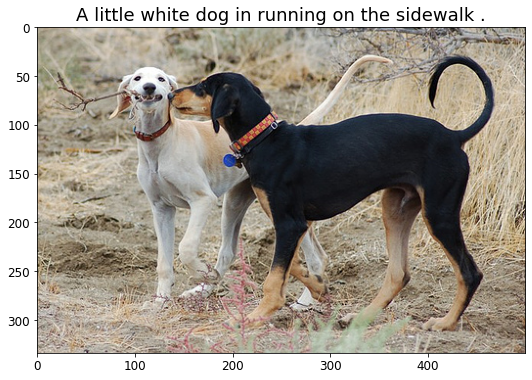

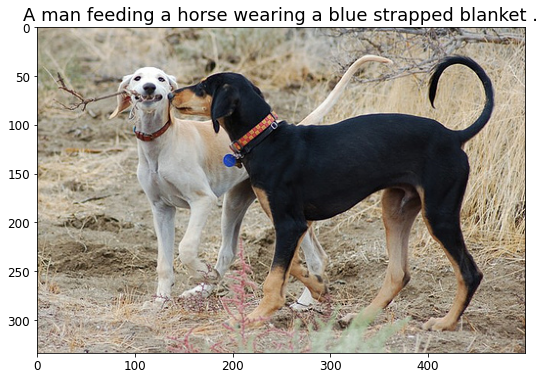

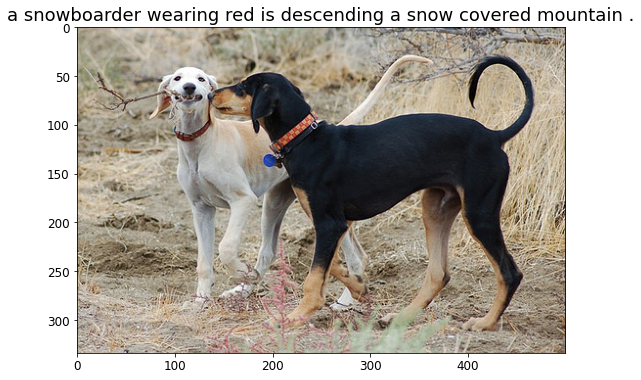

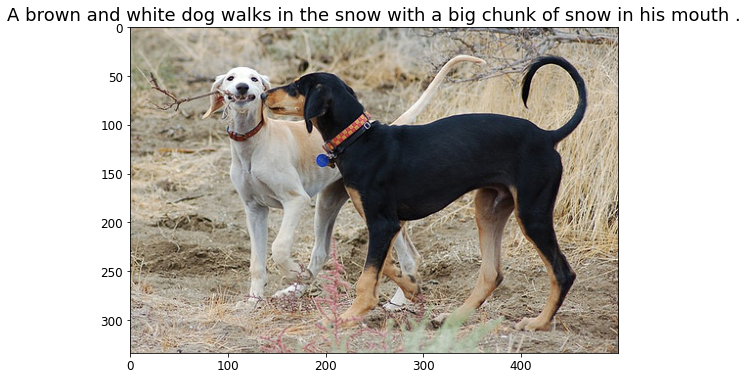

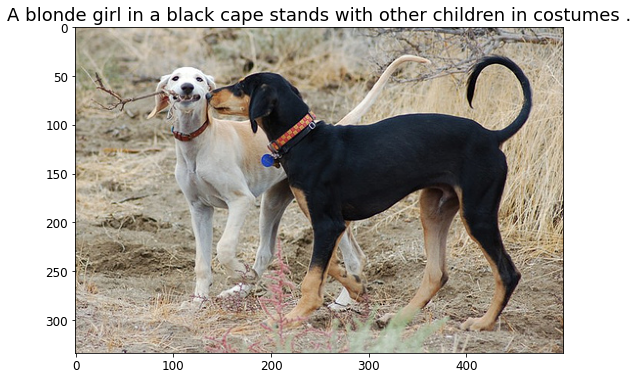

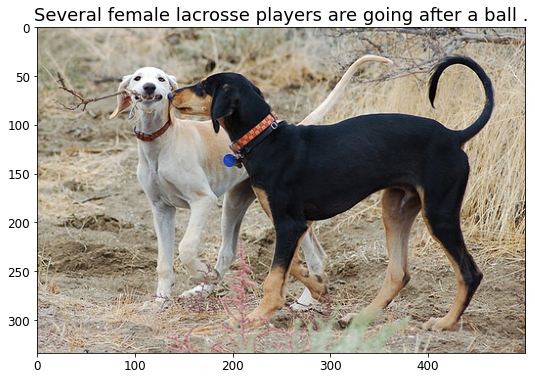

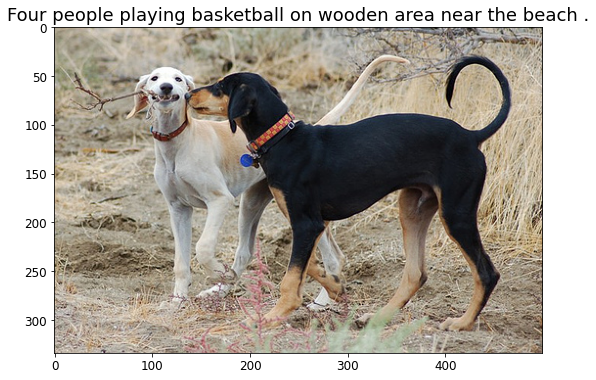

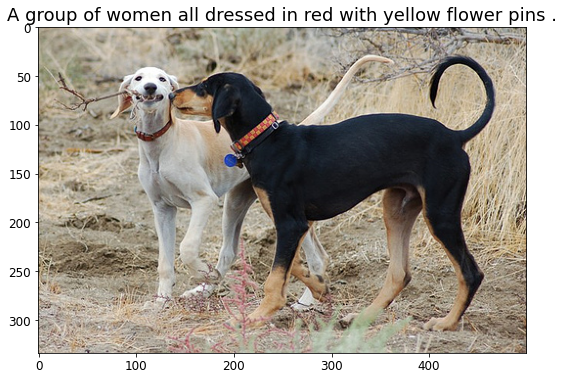

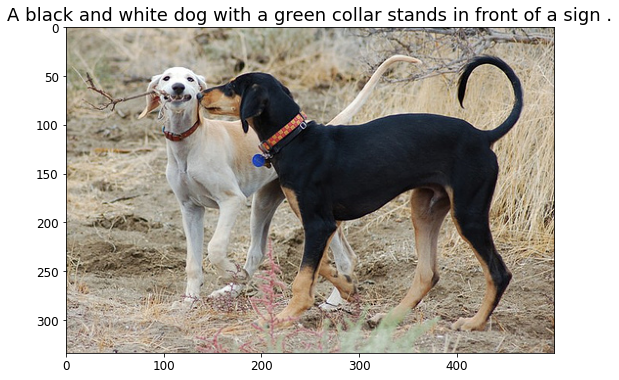

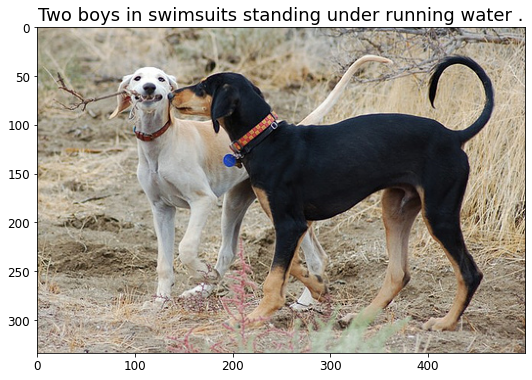

In [37]:
for sampled_query in sampled_queries:
    best_row_index = test_data[test_data['query_text'] == sampled_query][classes].mean(axis=1).argmax()
    plt.imshow(Image.open(test_data.loc[best_row_index, 'image']).convert('RGB'))
    plt.title(sampled_query)
    plt.show()

Либо в коде присутствуют баги и ошибки, либо модель плохо справилась с поставленной задачей :'(

## 8. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска